In [1]:
import os
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))  # This will show your GPU name if available

2.4.1+cu118
True
NVIDIA GeForce RTX 3060 Ti


In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import os
from torchvision.models import resnet50, ResNet50_Weights, resnet101, ResNet101_Weights , swin_t,efficientnet_b3,efficientnet_b2
import numpy as np 
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import cv2
from sklearn.metrics import roc_auc_score, classification_report,precision_recall_fscore_support,roc_curve, auc
from pathlib import Path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
from tqdm import tqdm
import math
from sklearn.preprocessing import  OneHotEncoder
import polars as pl
import albumentations as A

/home/davis/miniconda3/envs/cv/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
csv = 'train-metadata.csv'
df_train_meta = pd.read_csv(csv)

BASE_DATA_DIR = "."
BASE_IMG_DIR = os.path.join(BASE_DATA_DIR, "train-image/image")

df_train_meta["filepath"] = df_train_meta["isic_id"].apply(lambda x: f"{BASE_IMG_DIR}/{x}.jpg")

def read_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image    

/tmp/ipykernel_242154/1290047786.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_meta = pd.read_csv(csv)


In [6]:
df_train_meta.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

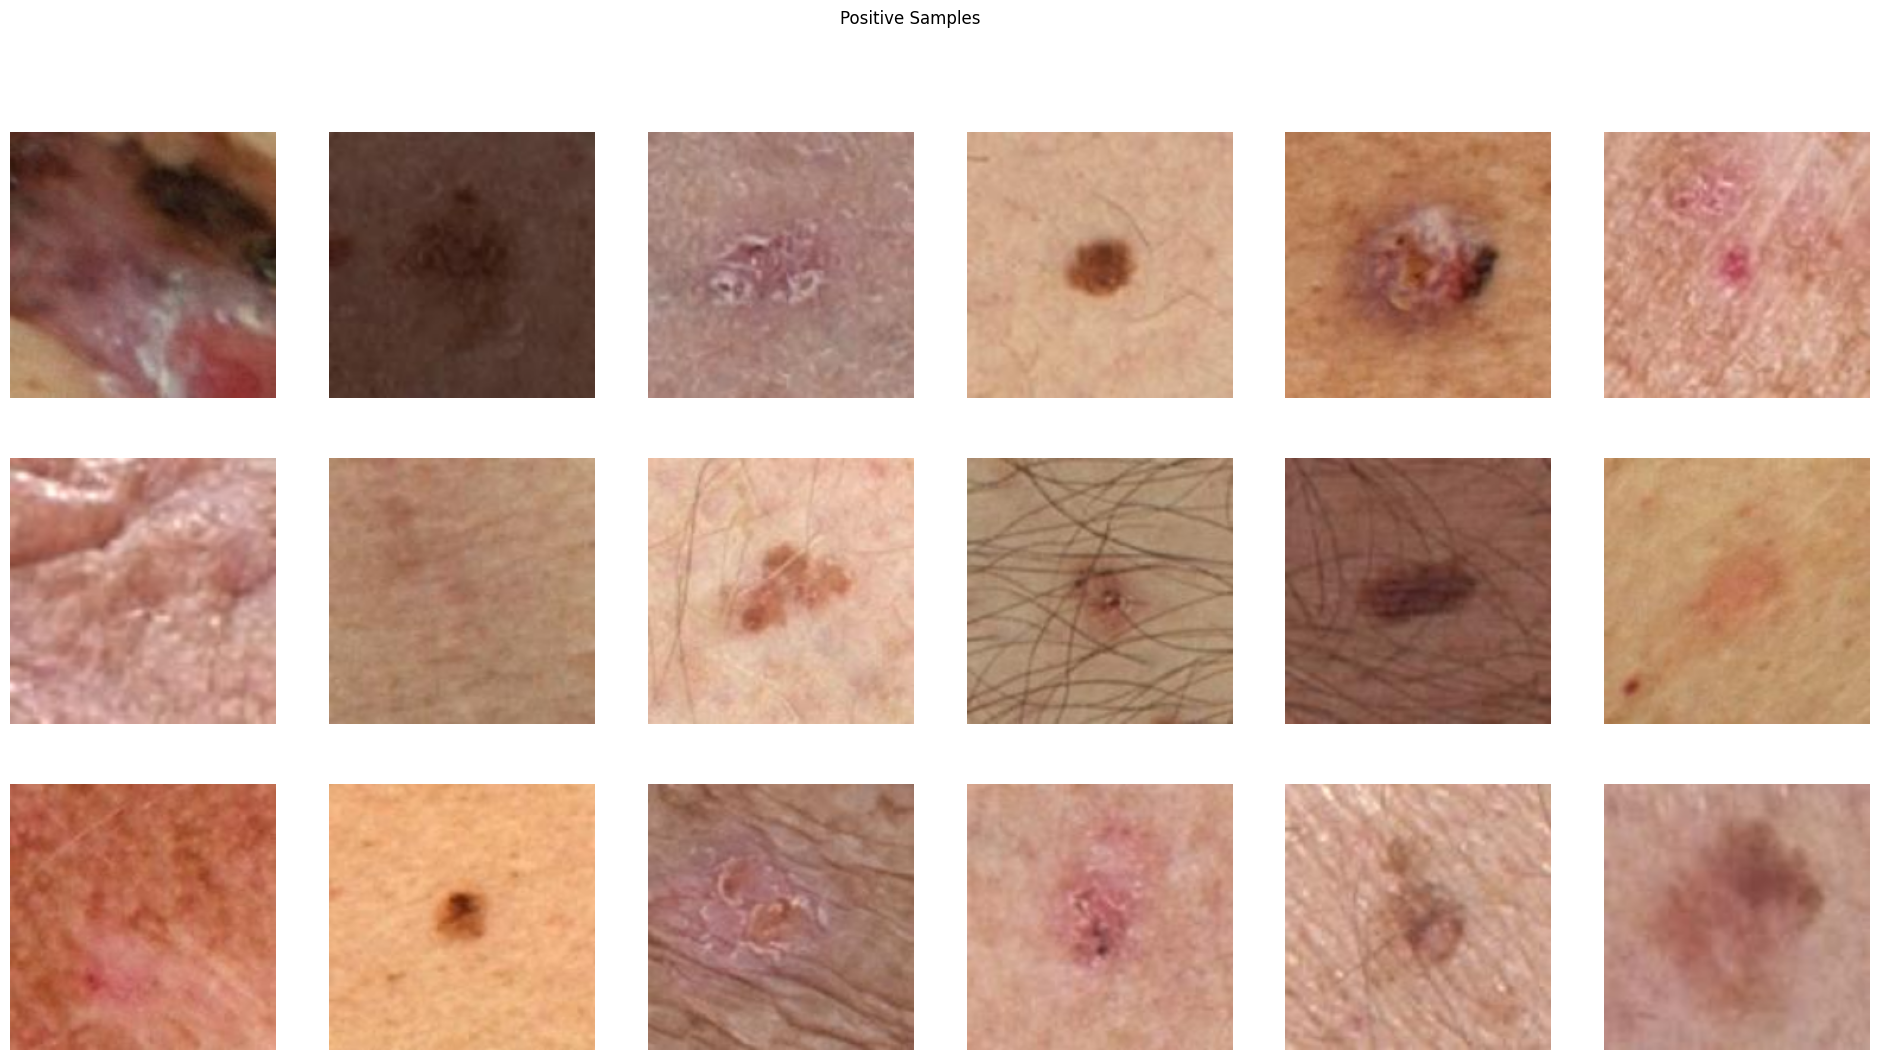

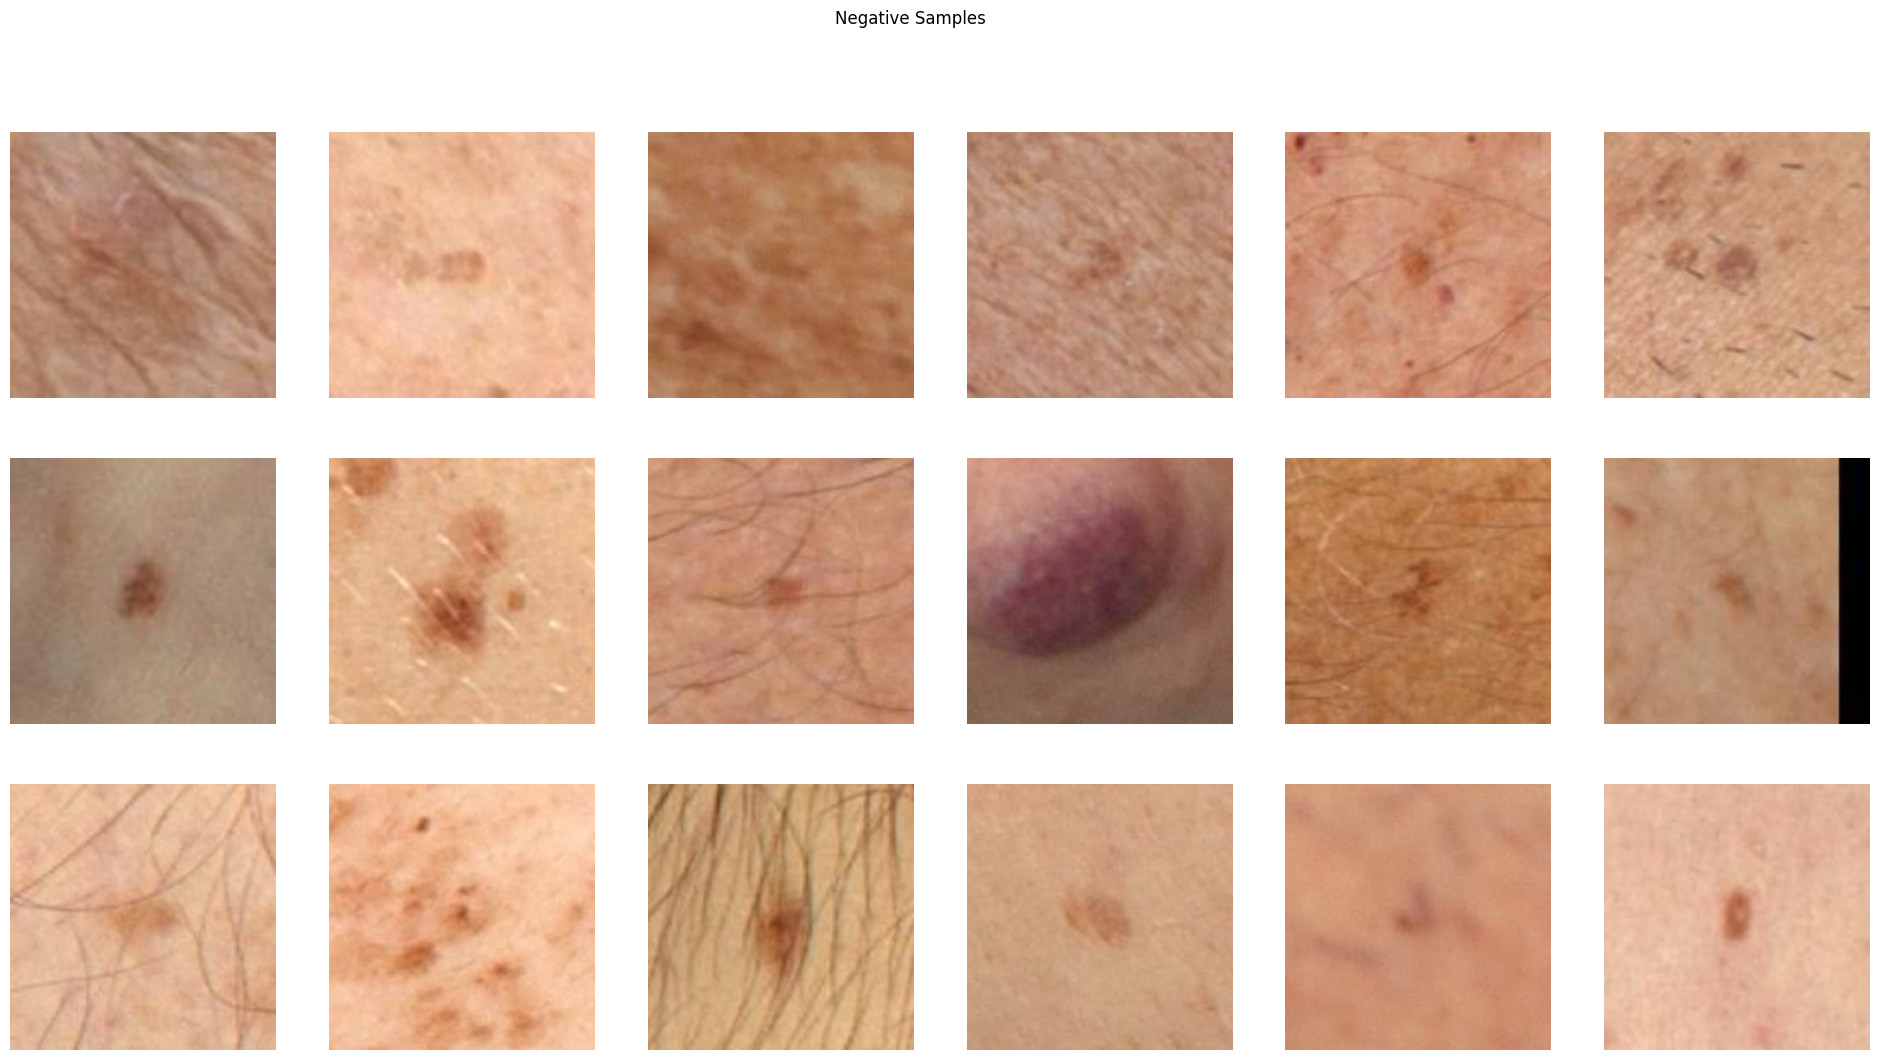

In [4]:
sample_image_paths = df_train_meta[df_train_meta["target"] == 1].sample(18, random_state=1)["filepath"].values
positive_images = [read_image(img_path) for img_path in sample_image_paths]
nrows, ncols = 3, 6
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 12))
axes = axes.ravel()
for image, ax in zip(positive_images, axes):
    ax.imshow(image)
    ax.axis("off")
fig.suptitle("Positive Samples")
plt.show()

sample_image_paths = df_train_meta[df_train_meta["target"] == 0].sample(18, random_state=1)["filepath"].values
negative_images = [read_image(img_path) for img_path in sample_image_paths]
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 12))
axes = axes.ravel()
for image, ax in zip(negative_images, axes):
    ax.imshow(image)
    ax.axis("off")
fig.suptitle("Negative Samples")
plt.show()

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_dataset_with_augmentations_balanced(df, test_size=0.1, val_size=0.11, random_state=42):
    """
    Split dataset ensuring equal class distribution in all splits while keeping
    original images and their augmentations together.
    """
    def get_group_sizes(group_df):
        return len(group_df)
    
    grouped = df.groupby('isic_id')
    group_sizes = grouped.apply(get_group_sizes)
    
    size_df = pd.DataFrame({
        'isic_id': group_sizes.index,
        'group_size': group_sizes.values,
        'label': [grouped.get_group(name)['label'].iloc[0] for name in group_sizes.index]
    })
    
    class_0_groups = size_df[size_df['label'] == 0]
    class_1_groups = size_df[size_df['label'] == 1]
    
    min_class_total = min(
        class_0_groups['group_size'].sum(),
        class_1_groups['group_size'].sum()
    )
    
    total_samples = min_class_total * 2 
    n_test = int(total_samples * test_size)
    n_val = int((total_samples - n_test) * val_size)
    n_train = total_samples - n_test - n_val
    
    n_test = (n_test // 2) * 2
    n_val = (n_val // 2) * 2
    n_train = total_samples - n_test - n_val
    
    def sample_groups_to_size(class_groups, target_size):
        """Sample groups to achieve target size including augmentations"""
        sampled_groups = []
        current_size = 0
        
        class_groups = class_groups.sort_values('group_size')
        
        for _, group in class_groups.iterrows():
            if current_size + group['group_size'] <= target_size:
                sampled_groups.append(group['isic_id'])
                current_size += group['group_size']
            else:
                break
                
        return sampled_groups
    
    for target_class in [0, 1]:
        class_groups = size_df[size_df['label'] == target_class]
        
        # Sample for test set
        test_names = sample_groups_to_size(class_groups, n_test // 2)
        remaining_groups = class_groups[~class_groups['isic_id'].isin(test_names)]
        
        # Sample for validation set
        val_names = sample_groups_to_size(remaining_groups, n_val // 2)
        remaining_groups = remaining_groups[~remaining_groups['isic_id'].isin(val_names)]
        
        # Sample for train set
        train_names = sample_groups_to_size(remaining_groups, n_train // 2)
        
        if target_class == 0:
            test_names_0, val_names_0, train_names_0 = test_names, val_names, train_names
        else:
            test_names_1, val_names_1, train_names_1 = test_names, val_names, train_names
    
    test_names = test_names_0 + test_names_1
    val_names = val_names_0 + val_names_1
    train_names = train_names_0 + train_names_1
    
    test_df = df[df['isic_id'].isin(test_names)].copy()
    val_df = df[df['isic_id'].isin(val_names)].copy()
    train_df = df[df['isic_id'].isin(train_names)].copy()
    
    try:
        test_df.to_csv('test_fromtrain_10percent.csv', index=False)
        print("Successfully saved test set to CSV")
    except Exception as e:
        print(f"Error saving test CSV: {str(e)}")
    stats = {
        'train': {
            'size': len(train_df),
            'distribution': train_df['label'].value_counts().to_dict()
        },
        'val': {
            'size': len(val_df),
            'distribution': val_df['label'].value_counts().to_dict()
        },
        'test': {
            'size': len(test_df),
            'distribution': test_df['label'].value_counts().to_dict()
        }
    }
        
    return train_df, val_df, test_df,stats

In [9]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, img_dim, metadata_dim):
        super().__init__()
        self.img_proj = nn.Linear(img_dim, 256)     
        self.key_proj = nn.Linear(metadata_dim, 256)  
        self.value_proj = nn.Linear(metadata_dim, 256) 
        self.output_proj = nn.Linear(256, img_dim)
        
        self.layer_norm = nn.LayerNorm(256)
        
    def forward(self, img_features, metadata):
        Q = self.img_proj(img_features).unsqueeze(1)     # [B, 1, 256]
        K = self.key_proj(metadata).unsqueeze(1)         # [B, 1, 256]
        V = self.value_proj(metadata).unsqueeze(1)       # [B, 1, 256]
        
        attention = torch.bmm(Q, K.transpose(1, 2)) / math.sqrt(256)
        attention = torch.softmax(attention, dim=-1)
        
        attended = torch.bmm(attention, V).squeeze(1)  # [B, 256]
        attended = self.layer_norm(attended)
        
        output = self.output_proj(attended)
        return img_features + output 
class HybridStructuredFusion(nn.Module):
    def __init__(self, img_dim, metadata_dim):
        super().__init__()
        
        self.meta_processor = nn.Sequential(
            nn.Linear(metadata_dim, img_dim),
            nn.LayerNorm(img_dim),
            nn.SiLU()
        )
        
        self.img_processor = nn.Sequential(
            nn.Linear(img_dim, img_dim),
            nn.LayerNorm(img_dim),
            nn.SiLU()
        )
        
        self.gate = nn.Sequential(
            nn.Linear(img_dim + metadata_dim, img_dim),
            nn.Sigmoid()
        )
        
        self.fusion = nn.Sequential(
            nn.Linear(2 * img_dim, img_dim),
            nn.LayerNorm(img_dim),
            nn.SiLU()
        )
        
    def forward(self, img_features, metadata):
        proc_meta = self.meta_processor(metadata) 
        proc_img = self.img_processor(img_features)
        
        gate = self.gate(torch.cat([img_features, metadata], dim=1))
        
        gated = torch.cat([
            proc_img * gate,
            proc_meta * (1 - gate)
        ], dim=1)
        
        output = self.fusion(gated)
        return img_features + output  
class MetaDataFineTuneResnet(nn.Module):
    def __init__(self, num_classes, metadata_dim, fusion_type='attention', freeze_layers=6):
        super().__init__()
        self.model = resnet101(weights='DEFAULT')
        self.metadata_dim = metadata_dim
        self.meta_dropout = nn.Dropout(0.3) 

        layers = list(self.model.named_children())
        for name, child in layers[:freeze_layers]:
            print(f"Freezing layer: {name}") 
            for param in child.parameters():
                param.requires_grad = False
                
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Identity()
   
        if fusion_type == 'attention':
            self.fusion = CrossAttentionFusion(num_ftrs, metadata_dim)
        else:  
            self.fusion = HybridStructuredFusion(num_ftrs, metadata_dim)
        self.meta_normalizer = nn.BatchNorm1d(metadata_dim)
        self.head = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
   
    def forward(self, x, metadata):
        x = self.model(x)
        metadata = self.meta_normalizer(metadata)
        metadata = self.meta_dropout(metadata)
        x = self.fusion(x, metadata)
        return self.head(x)

class BatchAlbumentation:
    def __init__(self, transform):
        self.transform = transform
        
    @torch.no_grad()
    def __call__(self, images, targets):
        if isinstance(images, torch.Tensor):
            images = images.numpy()
            
        if images.shape[1] == 3:  
            images = np.transpose(images, (0, 2, 3, 1))
        
        augmented = [self.transform(image=img)['image'] for img in images]
        aug_images = torch.stack(augmented)
        
        return aug_images, targets

def create_transforms(image_size=224):

    val_transform = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])
    transforms_train = A.Compose([
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.75
         ),
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        A.OneOf([
            A.OpticalDistortion(distort_limit=0.75),
            A.GridDistortion(num_steps=5, distort_limit=0.75),
            A.ElasticTransform(alpha=3),
        ], p=0.7),

        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        A.Resize(image_size,image_size),

        A.CoarseDropout(p=1.0),
        A.Normalize()
    ])

    transforms_val = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(),
        ToTensorV2()
    ])
    return transforms_train, transforms_val

class PreAugmentedMetadataMelanomaDataset(Dataset):
    def __init__(self, 
                 csv_file: pd.DataFrame,
                 metadata_cols: list,
                 transform: A.Compose = None,
                 use_augmented: bool = True):
        self.df = csv_file.copy()
        self.transform = transform
        self.metadata_cols = metadata_cols.copy()
        self.target_size = 224
        
        for col in self.metadata_cols:
            if col in self.df.columns: 
                self.df[col] = self.df[col].astype(np.float32)
        
        print(f"Number of metadata features: {len(self.metadata_cols)}")
        print(f"Sample metadata columns: {self.metadata_cols}...")
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        image = cv2.imread(row['path'])
        if image is None:
            raise ValueError(f"Could not load image at path: {row['path']}")
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        metadata_values = []
        for col in self.metadata_cols:
            if col in self.df.columns:
                val = row[col]
                metadata_values.append(val if not pd.isna(val) else 0.0)
            else:
                metadata_values.append(0.0)  
                
        metadata = torch.tensor(metadata_values, dtype=torch.float32)
        label = torch.tensor(row['label'], dtype=torch.long)
        
        return image, metadata, label
class MetadataAugmentationDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, 
                 batch_size=32, 
                 shuffle=True, 
                 num_workers=4, 
                 pin_memory=True,         
                 prefetch_factor=3,
                 persistent_workers=True,
                 batch_transform=None):
        
        def collate_fn(batch):
            images, metadata, labels = zip(*batch)
            images = torch.stack([torch.tensor(img) for img in images])
            metadata = torch.stack([meta for meta in metadata])
            labels = torch.stack([label for label in labels])
            return images, metadata, labels
        
        super().__init__(dataset, 
                         batch_size=batch_size, 
                         shuffle=shuffle, 
                         num_workers=num_workers,
                         pin_memory=pin_memory, 
                         prefetch_factor=prefetch_factor,
                         persistent_workers=persistent_workers,
                         collate_fn=collate_fn)

        self.batch_transform = batch_transform
        
    def __iter__(self):
        iterator = super().__iter__()
        if self.batch_transform is None:
            return iterator
        
        return map(self._transform_batch, iterator)
    
    def _transform_batch(self, batch):
        images, metadata, labels = batch
        if self.batch_transform:
            images, _ = self.batch_transform(images, labels)
        return images, metadata, labels
def custom_metric(y_true, y_pred, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.

    Args:
        y_true (array): True binary labels.
        y_pred (array): Predicted probabilities.
        min_tpr (float): Minimum TPR threshold (default: 0.8).

    Returns:
        float: Scaled pAUC value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    max_fpr = 1 - min_tpr  
    v_gt = abs(y_true - 1) 
    v_pred = 1.0 - y_pred  

    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc

def train_model_with_metadata(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience):
    """
    Training function with improved GPU utilization monitoring and debugging
    """
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
    
    model = model.to(device)
    print(f"Model device: {next(model.parameters()).device}")
    
    best_val_auc = 0
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',
        factor=0.5,
        patience=patience,
        verbose=True
    )
    

    print("\nStarting main training loop...")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []
        
        
        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for batch_idx, (inputs, metadata, labels) in enumerate(pbar):
            try:
                inputs = inputs.to(device, non_blocking=True)
                metadata = metadata.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                optimizer.zero_grad()
                
                outputs = model(inputs, metadata)
                loss = criterion(outputs, labels)
            
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                train_preds.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().detach().numpy())
                train_labels.extend(labels.cpu().numpy())
                
                if torch.cuda.is_available():
                  
                    pbar.set_postfix({
                        'loss': f'{loss.item():.4f}',
                 
                    })
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue
        
        if len(train_labels) == 0:
            print("No successful training batches in epoch")
            continue
            
        epoch_loss = running_loss / len(train_loader.dataset)
        train_auc = roc_auc_score(train_labels, train_preds)
        print(f'Epoch {epoch+1} - Loss: {epoch_loss:.4f}, AUC: {train_auc:.4f}')
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, metadata, labels in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}'):
                try:
                    inputs = inputs.to(device)
                    metadata = metadata.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(inputs, metadata)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item() * inputs.size(0)
                    val_preds.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())
                    
                except Exception as e:
                    print(f"Error in validation batch: {str(e)}")
                    traceback.print_exc()
                    continue
        
        if len(val_labels) == 0:
            print("No successful validation batches in epoch")
            continue
            
        val_loss = val_loss / len(val_loader.dataset)
        val_auc = roc_auc_score(val_labels, val_preds)
        
        scheduler.step(val_auc)
        
        print(f'\nEpoch {epoch+1} Results:')
        print(f'Train Loss: {epoch_loss:.4f} Train AUC: {train_auc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Val AUC: {val_auc:.4f}')
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_auc': best_val_auc,
            }, 'best_model_with_metadata.pth')
            print(f'New best model saved with validation AUC: {val_auc:.4f}')
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if no_improve_count >= patience * 2:
            print(f'\nEarly stopping triggered after {patience * 2} epochs without improvement')
            break
    
    return model
def read_data(path, num_cols, cat_cols):
    err = 1e-8
    id_col = 'isic_id'
    return (
        pl.from_pandas(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

def preprocess(df_train, df_test, feature_cols, cat_cols):
    """
    Preprocess the data by encoding categorical variables
    """
    feature_cols = feature_cols.copy()
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    print(cat_cols)
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]
    
    df_train_encoded = encoder.transform(df_train[cat_cols])
    df_test_encoded = encoder.transform(df_test[cat_cols])
    
    for i, col in enumerate(new_cat_cols):
        df_train[col] = pd.Categorical(df_train_encoded[:, i])
        df_test[col] = pd.Categorical(df_test_encoded[:, i])
    
    for col in cat_cols:
        if col in feature_cols:
            feature_cols.remove(col)
    feature_cols.extend(new_cat_cols)
    
    return df_train, df_test, feature_cols, new_cat_cols



def cross_validate_model_with_metadata(df_path, feature_cols, device, n_splits=5, base_model_path='swin_metadata_model'):
    """
    Perform k-fold cross validation with metadata support
    
    Args:
        df: DataFrame containing the dataset
        feature_cols: List of feature columns to use
        device: torch device (cuda/cpu)
        n_splits: Number of folds for cross-validation
        base_model_path: Base path for saving models (fold number will be appended)
    
    Returns:
        dict: Dictionary containing metrics for each fold and averages
    """
   
    df = pd.read_csv(df_path)
    df, val_df, _,stats = split_dataset_with_augmentations_balanced(df, test_size=0.001, val_size=0, random_state=42)
    print(stats)


    df_old = df.reset_index(drop=True)
    cat_cols = [col for col in feature_cols if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    num_cols = [col for col in feature_cols if col not in cat_cols]
    

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = defaultdict(list)

    groups = df.groupby('isic_id')['label'].first().reset_index()
    unique_ids = groups['isic_id'].values
    unique_labels = groups['label'].values

    for fold, (train_idx, val_idx) in enumerate(skf.split(unique_ids, unique_labels)):
        print(f"\nProcessing fold {fold + 1}/{n_splits}")
        
        train_ids = unique_ids[train_idx]
        val_ids = unique_ids[val_idx]
        df = df_old.reset_index()

        train_df = df[df['isic_id'].isin(train_ids)].copy()
        val_df = df[df['isic_id'].isin(val_ids)].copy()

        print(len(train_df[train_df['label'] ==1])/len(train_df))
        print(len(val_df[val_df['label'] ==1])/len(val_df))

        train_df = read_data(train_df, num_cols, cat_cols)
        val_df = read_data(val_df, num_cols, cat_cols)

        print("Preprocessing data...")
        train_processed, val_processed, updated_feature_cols, new_cat_cols = preprocess(
            train_df, val_df, feature_cols, cat_cols
        )
        print(len(train_processed.columns))
        print(train_processed.columns)

        train_transform, val_transform = create_transforms(image_size=224)
        val_batch_transform = BatchAlbumentation(val_transform)
        
        train_dataset = PreAugmentedMetadataMelanomaDataset(
            csv_file=train_processed,
            metadata_cols=updated_feature_cols,
            transform=None,
            use_augmented=True
        )
        
        val_dataset = PreAugmentedMetadataMelanomaDataset(
            csv_file=val_processed,
            metadata_cols=updated_feature_cols,
            transform=None,
            use_augmented=False
        )
        
        train_loader = MetadataAugmentationDataLoader(
            train_dataset,
            batch_size=64,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            prefetch_factor=3,
            persistent_workers=True,
            batch_transform=val_batch_transform
        )
        
        val_loader = MetadataAugmentationDataLoader(
            val_dataset,
            batch_size=64,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
            prefetch_factor=3,
            persistent_workers=True,
            batch_transform=val_batch_transform
        )
        
        num_classes = len(df['label'].unique())
        metadata_dim = len(updated_feature_cols)
        model = MetaDataFineTuneResnet(num_classes=num_classes, metadata_dim=metadata_dim, fusion_type='attention')

        model = model.to(device)
        
        class_weights = torch.tensor([1.0, 1.0]).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=0.00091, betas=(0.9, 0.999))

        model = train_model_with_metadata(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=80,
        device=device,
        patience=3
    )
    
        fold_model_path = f"{base_model_path}_fold{fold+1}.pth"
        torch.save(model.state_dict(), fold_model_path)
        print(f"Saved model for fold {fold+1} to {fold_model_path}")
        
        model.eval()
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for images, metadata, labels in val_loader:
                images = images.to(device)
                metadata = metadata.to(device)
                labels = labels.to(device)
                
                outputs = model(images, metadata)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                
                val_preds.extend(probs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        fold_auc = roc_auc_score(val_labels, val_preds)
        fold_pauc = custom_metric(val_labels, val_preds)
        binary_preds = [1 if p >= 0.5 else 0 for p in val_preds]
        fold_report = classification_report(val_labels, binary_preds, output_dict=True)
        
        metrics['auc'].append(fold_auc)
        metrics['fold_pauc'].append(fold_pauc)
        metrics['precision'].append(fold_report['weighted avg']['precision'])
        metrics['recall'].append(fold_report['weighted avg']['recall'])
        metrics['f1'].append(fold_report['weighted avg']['f1-score'])
        
        print(f"\nFold {fold+1} Results:")
        print(f"AUC: {fold_auc:.4f}")
        print(f"pAUC: {fold_pauc:.4f}")

        print(f"Precision: {fold_report['weighted avg']['precision']:.4f}")
        print(f"Recall: {fold_report['weighted avg']['recall']:.4f}")
        print(f"F1: {fold_report['weighted avg']['f1-score']:.4f}")
    

    print("\nAverage Metrics Across All Folds:")
    average_metrics = {
        'auc': np.mean(metrics['auc']),
        'pauc' : np.mean(metrics['fold_pauc']),
        'precision': np.mean(metrics['precision']),
        'recall': np.mean(metrics['recall']),
        'f1': np.mean(metrics['f1']),
        'auc_std': np.std(metrics['auc']),
        'pauc_std': np.std(metrics['fold_pauc']),

        'precision_std': np.std(metrics['precision']),
        'recall_std': np.std(metrics['recall']),
        'f1_std': np.std(metrics['f1'])
    }
    
    print(f"Average AUC: {average_metrics['auc']:.4f} ± {average_metrics['auc_std']:.4f}")
    print(f"Average pAUC: {average_metrics['pauc']:.4f} ± {average_metrics['pauc_std']:.4f}")

    print(f"Average Precision: {average_metrics['precision']:.4f} ± {average_metrics['precision_std']:.4f}")
    print(f"Average Recall: {average_metrics['recall']:.4f} ± {average_metrics['recall_std']:.4f}")
    print(f"Average F1: {average_metrics['f1']:.4f} ± {average_metrics['f1_std']:.4f}")
    
    return metrics, average_metrics



In [ ]:

num_cols = [
    'age_approx',                        
    'clin_size_long_diam_mm',            
    'tbp_lv_A',                          
    'tbp_lv_Aext',                       
    'tbp_lv_B',                          
    'tbp_lv_Bext',                       
    'tbp_lv_C',                          
    'tbp_lv_Cext',                       
    'tbp_lv_H',                         
    'tbp_lv_Hext',                      
    'tbp_lv_L',                         
    'tbp_lv_Lext',                      
    'tbp_lv_areaMM2',                   
    'tbp_lv_area_perim_ratio',          
    'tbp_lv_color_std_mean',            
    'tbp_lv_deltaA',                    
    'tbp_lv_deltaB',                    
    'tbp_lv_deltaL',                    
    'tbp_lv_deltaLB',                   
    'tbp_lv_deltaLBnorm',               
    'tbp_lv_eccentricity',             
    'tbp_lv_minorAxisMM',              
    'tbp_lv_nevi_confidence',          
    'tbp_lv_norm_border',              
    'tbp_lv_norm_color',               
    'tbp_lv_perimeterMM',              
    'tbp_lv_radial_color_std_max',     
    'tbp_lv_stdL',                     
    'tbp_lv_stdLExt',                  
    'tbp_lv_symm_2axis',             
    'tbp_lv_symm_2axis_angle',         
    'tbp_lv_x',                        
    'tbp_lv_y',                         
    'tbp_lv_z',                         
]
cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']

feature_cols = num_cols + cat_cols 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metrics, average_metrics = cross_validate_model_with_metadata(
                                                            df_path='merged_output.csv',
                                                            feature_cols=feature_cols,  
                                                            device=device,
                                                            n_splits=5,
                                                            base_model_path='swin_metadata_model'
                                                            )


Successfully saved test set to CSV
{'train': {'size': 6276, 'distribution': {0: 3140, 1: 3136}}, 'val': {'size': 0, 'distribution': {}}, 'test': {'size': 2, 'distribution': {0: 2}}}

Processing fold 1/5
0.49920255183413076
0.5015873015873016
Preprocessing data...
['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
92
Index(['index', 'original_name', 'path', 'label', 'is_augmented',
       'augmented_name', 'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radia

/home/davis/miniconda3/envs/cv/lib/python3.8/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


Freezing layer: conv1
Freezing layer: bn1
Freezing layer: relu
Freezing layer: maxpool
Freezing layer: layer1
Freezing layer: layer2
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Ti
Model device: cuda:0
Testing data pipeline with single batch...


/home/davis/miniconda3/envs/cv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test batch loaded successfully:
Inputs shape: torch.Size([64, 3, 224, 224]), device: cpu
Metadata shape: torch.Size([64, 80]), device: cpu
Labels shape: torch.Size([64]), device: cpu
Forward pass successful

Starting main training loop...

Epoch 1/80
----------


Training Epoch 1: 100%|██████████| 79/79 [12:18<00:00,  9.35s/it, loss=0.3158]


Epoch 1 - Loss: 0.4061, AUC: 0.8981


Validation Epoch 1: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]



Epoch 1 Results:
Train Loss: 0.4061 Train AUC: 0.8981
Val Loss: 0.3428 Val AUC: 0.9300
New best model saved with validation AUC: 0.9300

Epoch 2/80
----------


Training Epoch 2: 100%|██████████| 79/79 [11:46<00:00,  8.94s/it, loss=0.4967]


Epoch 2 - Loss: 0.3443, AUC: 0.9270


Validation Epoch 2: 100%|██████████| 20/20 [01:06<00:00,  3.33s/it]



Epoch 2 Results:
Train Loss: 0.3443 Train AUC: 0.9270
Val Loss: 0.3432 Val AUC: 0.9276

Epoch 3/80
----------


Training Epoch 3:   4%|▍         | 3/79 [00:46<22:18, 17.61s/it, loss=0.2458]